In [2]:
import pandas as pd       # For data manipulation and analysis
import numpy as np        # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For plotting]

import sys
import os

from scipy.stats import *
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import powerlaw

# Get the current working directory and then go up to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Import everything from visualize_return.py
from visualize_return import *

## Fill Probability

In [3]:

# message_data = pd.read_csv("combined_messages_.csv")
message_data = pd.read_csv("combined_messages_2024-08-12.csv")


message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction',     # -1 for sell, 1 for buy
    # 'NotUsed',      # Not used, for alignment purposes
]

message_data.columns = message_column_names

print(message_data.shape)

# Drop first row
message_data = message_data.drop(0)

# Drop NotUsed column
# message_data = message_data.drop(columns=['NotUsed'])

(1438228, 6)


In [4]:
# book_data = pd.read_csv("combined_orderbooks_.csv")
book_data = pd.read_csv("combined_orderbooks_2024-08-12.csv")

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

# Drop first row
book_data = book_data.drop(0)

(1438228, 40)


In [5]:
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

message_data['Time'] = pd.to_datetime(message_data['Time'])
book_data['Time'] = pd.to_datetime(book_data['Time'])

message_data.set_index('Time', inplace=True)
book_data.set_index('Time', inplace=True)

In [6]:
# Mid-price calculation
book_data['MidPrice'] = (book_data['AskPrice1'] + book_data['BidPrice1']) / 2

message_data['MidPrice'] = book_data['MidPrice']

message_data['BestBid'] = book_data['BidPrice1']

message_data['BestAsk'] = book_data['AskPrice1']

In [7]:
book_data.head()

,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10,MidPrice
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-12 09:30:00.049734400,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,211,1686000,200,1676600,1,1686800,156,1676500,5,1680700.0
2024-08-12 09:30:00.103421696,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,211,1686000,200,1676600,1,1686800,156,1676500,5,1680700.0
2024-08-12 09:30:00.114824448,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,211,1686000,200,1676600,1,1686800,156,1676500,5,1680700.0
2024-08-12 09:30:00.146436096,1681400,336,1680000,1112,1684000,200,1679900,72,1684100,89,...,211,1686000,200,1676600,1,1686800,156,1676500,5,1680700.0
2024-08-12 09:30:00.150553088,1681400,300,1680000,1112,1684000,200,1679900,72,1684100,89,...,211,1686000,200,1676600,1,1686800,156,1676500,5,1680700.0


In [8]:
message_data.head()

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk
Time,,,,,,,,
2024-08-12 09:30:00.049734400,1,25496857,200,1680000,1,1680700.0,1680000,1681400
2024-08-12 09:30:00.103421696,5,0,663,1681200,1,1680700.0,1680000,1681400
2024-08-12 09:30:00.114824448,5,0,20,1681200,1,1680700.0,1680000,1681400
2024-08-12 09:30:00.146436096,1,25566253,300,1681400,-1,1680700.0,1680000,1681400
2024-08-12 09:30:00.150553088,4,25496365,36,1681400,-1,1680700.0,1680000,1681400


### Fill probability (eventually filled)

In [9]:
print("By order numbers:")

# Define market order event types (executions)
market_order_types = [4, 5]  # Event Types 4 and 5 indicate executions

# Count the number of market orders in message_data
market_order_count = message_data[message_data['EventType'].isin(market_order_types)].shape[0]

# Calculate the total number of orders
total_orders = len(message_data)

# Calculate the percentage of market orders
market_order_percentage = (market_order_count / total_orders) * 100

print(f"Percentage of market orders {market_order_percentage:.4f}%")

hidden_order_types = [5]  # Event Types 6 and 7 indicate hidden orders

# Count the number of hidden orders in message_data
hidden_order_count = message_data[message_data['EventType'].isin(hidden_order_types)].shape[0]

# Calculate the percentage of hidden orders
hidden_order_percentage = (hidden_order_count / market_order_count) * 100

print(f"Percentage of hidden orders in market orders {hidden_order_percentage:.4f}%")

print("By volume:")

# Calculate the total volume of market orders
market_order_volume = message_data[message_data['EventType'].isin(market_order_types)]['Size'].sum()

# Calculate the total volume of hidden orders
hidden_order_volume = message_data[message_data['EventType'].isin(hidden_order_types)]['Size'].sum()

# Calculate the percentage of hidden order volume
hidden_order_volume_percentage = (hidden_order_volume / market_order_volume) * 100

print(f"Percentage of hidden order volume in market order volume {hidden_order_volume_percentage:.4f}%")

By order numbers:
Percentage of market orders 6.3402%
Percentage of hidden orders in market orders 16.7624%
By volume:
Percentage of hidden order volume in market order volume 16.9332%


In [10]:
post_order_types = [1]  # Event Type 1 indicates a posted order

posted_orders_count = message_data[message_data['EventType'].isin(post_order_types)].shape[0]
posted_orders_volume = message_data[message_data['EventType'].isin(post_order_types)]['Size'].sum()

cancel_order_types = [2, 3]  # Event Types 2 and 3 indicate cancellations

# Count the number of cancelled orders in message_data
cancel_order_count = message_data[message_data['EventType'].isin(cancel_order_types)].shape[0]

# Calculate the percentage of cancelled orders
cancel_order_percentage = (cancel_order_count / posted_orders_count) * 100

print(f"Percentage of cancelled orders {cancel_order_percentage:.4f}%")

# VOLUME weighted cancel percentage

# Calculate the total volume of orders
total_volume = message_data['Size'].sum()

# Calculate the volume of cancelled orders
cancel_order_volume = message_data[message_data['EventType'].isin(cancel_order_types)]['Size'].sum()

# Calculate the volume weighted cancel percentage
cancel_order_volume_percentage = (cancel_order_volume / posted_orders_volume) * 100

print(f"Volume weighted cancel percentage {cancel_order_volume_percentage:.4f}%")

print("Disclaimer: this is an approximation only, as not all canceled are posted in the same trading day, which is the data we have.")


Percentage of cancelled orders 91.2847%
Volume weighted cancel percentage 91.6673%
Disclaimer: this is an approximation only, as not all canceled are posted in the same trading day, which is the data we have.


In [11]:
# Step 1: Calculate depth at posting (integer verified)
message_data['DepthAtPosting'] = message_data.apply(
    lambda row: abs(row['Price'] - row['BestBid']) // 100 if row['Direction'] == 1 
    else abs(row['Price'] - row['BestAsk']) // 100,
    axis=1
)    


In [12]:
message_data.head(10)  

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk,DepthAtPosting
Time,,,,,,,,,
2024-08-12 09:30:00.049734400,1,25496857,200,1680000,1,1680700.0,1680000,1681400,0.0
2024-08-12 09:30:00.103421696,5,0,663,1681200,1,1680700.0,1680000,1681400,12.0
2024-08-12 09:30:00.114824448,5,0,20,1681200,1,1680700.0,1680000,1681400,12.0
2024-08-12 09:30:00.146436096,1,25566253,300,1681400,-1,1680700.0,1680000,1681400,0.0
2024-08-12 09:30:00.150553088,4,25496365,36,1681400,-1,1680700.0,1680000,1681400,0.0
2024-08-12 09:30:00.150553088,4,25566253,300,1681400,-1,1682000.0,1680000,1684000,26.0
2024-08-12 09:30:00.150584320,1,25568921,100,1680300,1,1682150.0,1680300,1684000,0.0
2024-08-12 09:30:00.150608640,1,25568941,8,1680200,1,1682150.0,1680300,1684000,1.0
2024-08-12 09:30:00.151613952,3,25568941,8,1680200,1,1682150.0,1680300,1684000,1.0


In [13]:
import pandas as pd

# Initialize data structures
filled_depth_count = {}  # Depth -> Total filled size
posted_depth_count = {}  # Depth -> Total posted size
order_depth_map = {}     # Order ID -> Depth posted
order_size_map = {}      # Order ID -> Size posted

# Process the message data row by row
for index, row in message_data.iterrows():
    # Extract relevant fields
    event_type = row['EventType']      # Type of event (1: Add, 2: Partial Cancel, etc.)
    order_id = row['OrderID']          # Unique ID for the order
    size = row['Size']                 # Size of the order/event
    depth = row['DepthAtPosting']      # Depth at which the order was posted

    # Event type 1: New order posted to the book
    if event_type == 1:
        order_depth_map[order_id] = depth
        order_size_map[order_id] = size
        if depth not in posted_depth_count:
            posted_depth_count[depth] = 0
        posted_depth_count[depth] += size

    # # Event type 2: Partial cancellation of an existing order
    # elif event_type == 2:
    #     if order_id in order_depth_map:
    #         order_size_map[order_id] -= size
    #         posted_depth_count[order_depth_map[order_id]] -= size
    #         if posted_depth_count[order_depth_map[order_id]] < 0:
    #             raise ValueError(f"Negative size detected for depth {order_depth_map[order_id]}")

    #         if order_size_map[order_id] < 0:
    #             raise ValueError(f"Negative size detected for order {order_id}, likely an implementation error")   

    # # Event type 3: Full cancellation of an existing order
    # elif event_type == 3:
    #     if order_id in order_depth_map:
    #         depth = order_depth_map[order_id]
    #         posted_depth_count[depth] -= order_size_map[order_id]
    #         post_debug_string += f"Order {order_id} fully cancelled and size deducted by {order_size_map[order_id]}\n"
    #         # Remove order from tracking maps
    #         del order_depth_map[order_id]
    #         del order_size_map[order_id]

    # Event type 4: Market order fill
    elif event_type == 4:
        if order_id in order_depth_map:
            depth = order_depth_map[order_id]
            if depth not in filled_depth_count:
                filled_depth_count[depth] = 0
            filled_depth_count[depth] += size
            # Reduce the remaining size for the order
            order_size_map[order_id] -= size

    # Ignore other event types

# Convert dictionaries to DataFrames
posted_df = pd.DataFrame(posted_depth_count.items(), columns=['Depth', 'PostedOrders'])
filled_df = pd.DataFrame(filled_depth_count.items(), columns=['Depth', 'FilledOrders'])

# Merge posted and filled data
depth_data = pd.merge(posted_df, filled_df, on='Depth', how='left').fillna(0)

# Ensure numeric types for calculations
depth_data['PostedOrders'] = depth_data['PostedOrders'].astype(float)
depth_data['FilledOrders'] = depth_data['FilledOrders'].astype(float)

# Sort by depth
depth_data = depth_data.sort_values(by='Depth')

total_filled_orders = depth_data['FilledOrders'].sum()
total_posted_orders = depth_data['PostedOrders'].sum()

print("Total filled orders:", total_filled_orders)
print("Total posted orders:", total_posted_orders)

# Filter depths and calculate fill probability
depth_data['FillProbability'] = depth_data['FilledOrders'] / depth_data['PostedOrders']

# New column called AggFillProbability, calculated as propotion of orders that from certain depth that are filled
depth_data['AggFillProbability'] = depth_data['FilledOrders'].cumsum() / total_filled_orders

depth_data['PerDepthFillProbability'] = depth_data['FilledOrders'] / total_filled_orders

# Cutoff where aggregate fill probability is 0.99
cutoff_depth = depth_data[depth_data['AggFillProbability'] >= 0.99].iloc[0]['Depth']
print("Cutoff depth for 99% fill probability:", cutoff_depth)

depth_data = depth_data[depth_data['Depth'] <= cutoff_depth]

depth_data



Total filled orders: 3562727.0
Total posted orders: 47701650.0
Cutoff depth for 99% fill probability: 8.0


,Depth,PostedOrders,FilledOrders,FillProbability,AggFillProbability,PerDepthFillProbability
0,0.0,24122473.0,2823531.0,0.117050,0.792520,0.792520
1,1.0,7783143.0,309869.0,0.039813,0.879495,0.086975
5,2.0,4061038.0,114763.0,0.028260,0.911707,0.032212
12,3.0,3553016.0,77370.0,0.021776,0.933423,0.021717
15,4.0,3754505.0,82031.0,0.021849,0.956448,0.023025
14,5.0,1093780.0,47597.0,0.043516,0.969808,0.013360
10,6.0,826758.0,27913.0,0.033762,0.977643,0.007835
6,7.0,796436.0,30758.0,0.038620,0.986276,0.008633
11,8.0,1172688.0,34088.0,0.029068,0.995844,0.009568


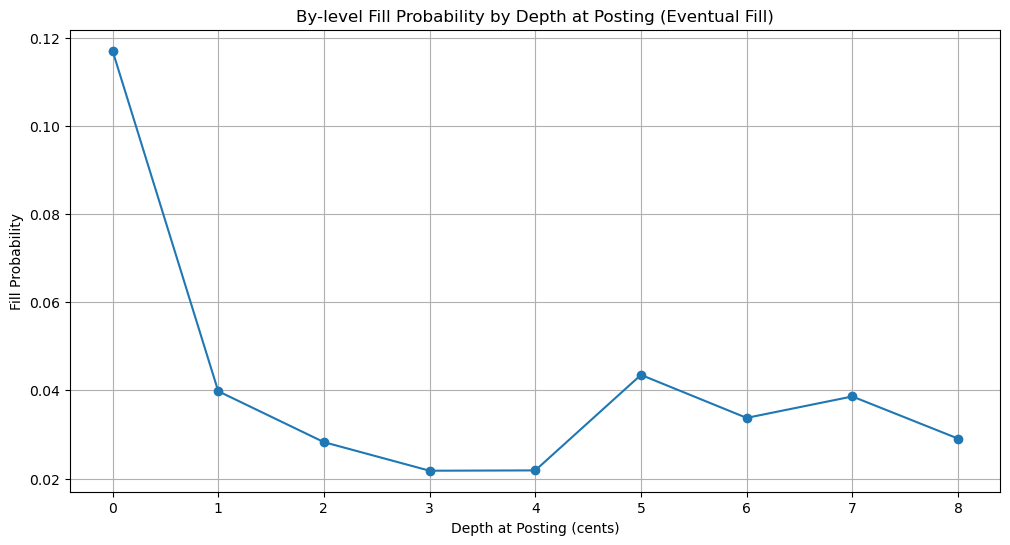

In [14]:
# Plot fill probability by depth
# x-axis DepthAtPosting the median of each bin
# y-axis AvgFillProbability the average fill probability of each bin
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data['Depth'],
    depth_data['FillProbability'],
    marker='o'
)

plt.xlabel('Depth at Posting (cents)')
plt.ylabel('Fill Probability')
plt.title('By-level Fill Probability by Depth at Posting (Eventual Fill)')
plt.grid(True)
plt.show()

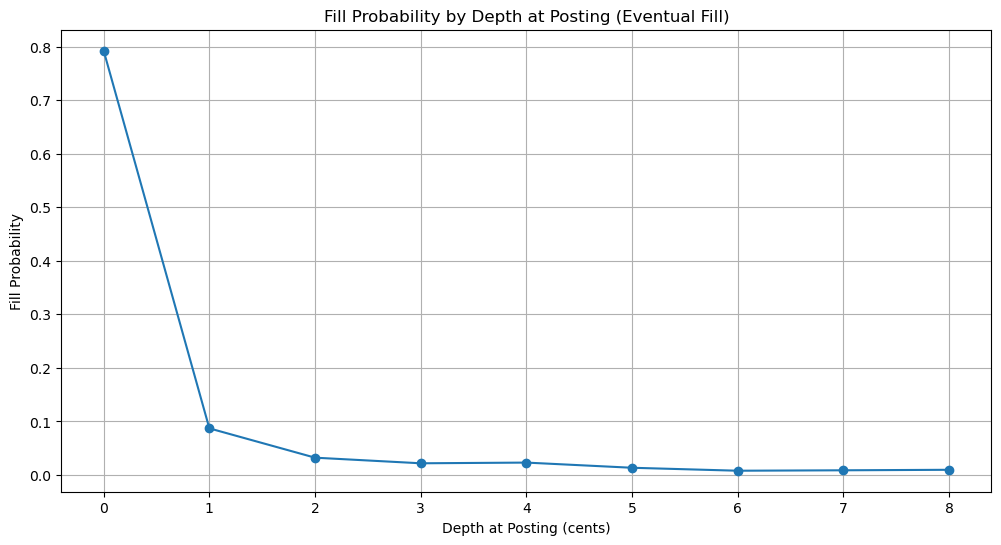

In [15]:
# Plot fill probability by depth
# x-axis DepthAtPosting the median of each bin
# y-axis AvgFillProbability the average fill probability of each bin
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data['Depth'],
    depth_data['PerDepthFillProbability'],
    marker='o'
)

plt.xlabel('Depth at Posting (cents)')
plt.ylabel('Fill Probability')
plt.title('Fill Probability by Depth at Posting (Eventual Fill)')
plt.grid(True)
plt.show()

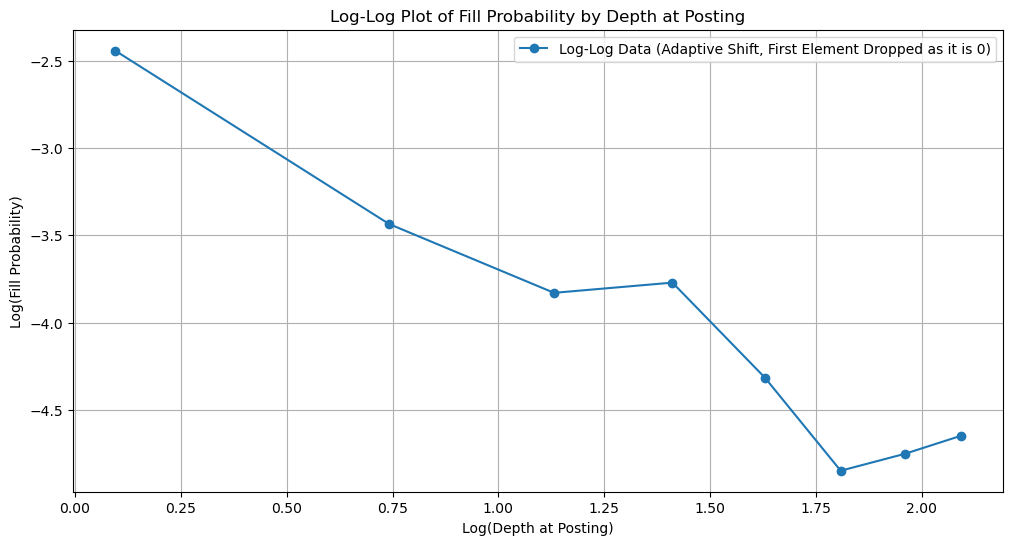

Slope: -1.1663, Intercept: -2.4209


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Copy the Depth and PerDepthFillProbability columns to preserve original data
x = depth_data['Depth'].copy()
y = depth_data['PerDepthFillProbability'].copy()

# Drop the first element from the copied data
x = x.iloc[1:].reset_index(drop=True)
y = y.iloc[1:].reset_index(drop=True)

# Adaptive shift: Use a fraction of the smallest non-zero value in x
min_nonzero = x[x > 0].min()
shift = 0.1 * min_nonzero  # Small adaptive shift based on minimum value

# Add shift to all x values
x_shifted = x + shift

# Apply log transformation
x_log = np.log(x_shifted)
y_log = np.log(y)

# Plot log-log data
plt.figure(figsize=(12, 6))
plt.plot(
    x_log, y_log, marker='o', label='Log-Log Data (Adaptive Shift, First Element Dropped as it is 0)'
)

plt.xlabel('Log(Depth at Posting)')
plt.ylabel('Log(Fill Probability)')
plt.title('Log-Log Plot of Fill Probability by Depth at Posting')
plt.grid(True)
plt.legend()
plt.show()

# Fit a linear regression model to the log-log data
model = LinearRegression(fit_intercept=True)
model.fit(x_log.values.reshape(-1, 1), y_log)
slope = model.coef_[0]
intercept = model.intercept_
r2_score = model.score(x_log.values.reshape(-1, 1), y_log)

print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")





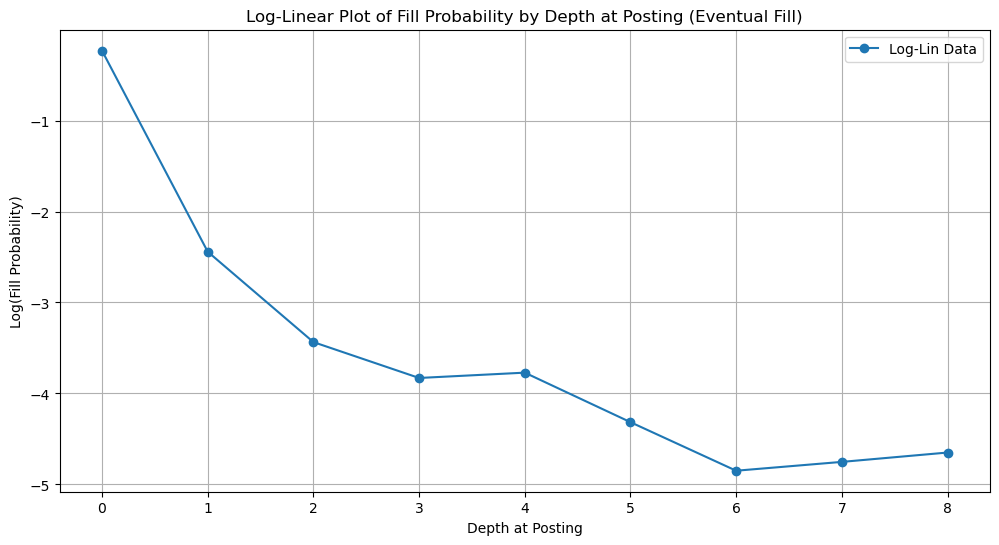

In [17]:
# Log-linear plot. 
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data['Depth'],
    np.log(depth_data['PerDepthFillProbability']),
    marker='o', label='Log-Lin Data'
)

plt.xlabel('Depth at Posting')
plt.ylabel('Log(Fill Probability)')
plt.title('Log-Linear Plot of Fill Probability by Depth at Posting (Eventual Fill)')
plt.grid(True)
plt.legend()
plt.show()

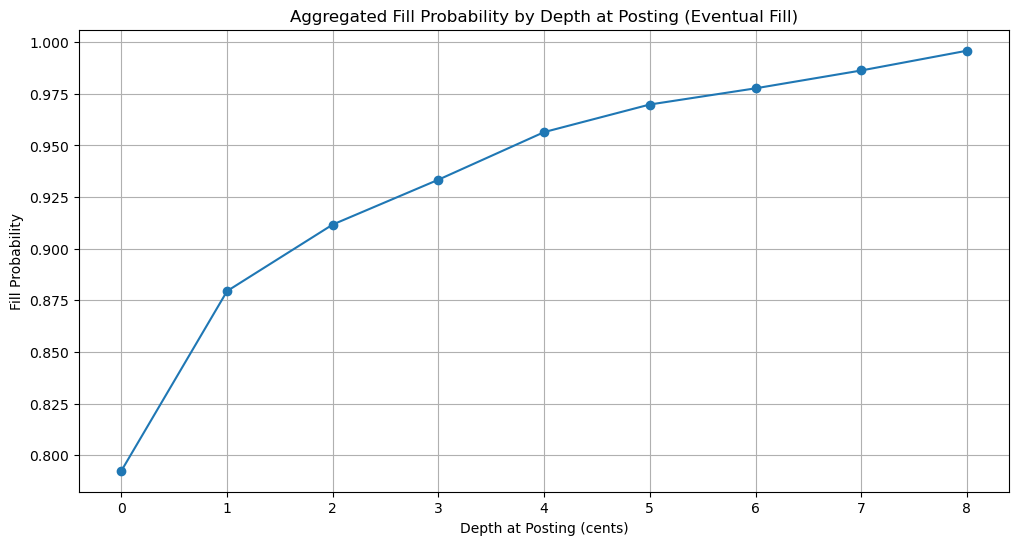

In [18]:
# Visualize Depth vs AggFillProbability
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data['Depth'],
    depth_data['AggFillProbability'],
    marker='o'
)

plt.xlabel('Depth at Posting (cents)')
plt.ylabel('Fill Probability')
plt.title('Aggregated Fill Probability by Depth at Posting (Eventual Fill)')
plt.grid(True)
plt.show()

Plot confirms a power law fit. 
See https://www.cambridge.org/core/books/abs/fundamentals-of-heavy-tails/estimating-powerlaw-distributions-listen-to-the-body/471FF6503315B410A2228E351AD7BDA3

In [19]:
# Only show two columns of depth data Depth and PerDepthFillProbability
depth_data[['Depth', 'PerDepthFillProbability']]

,Depth,PerDepthFillProbability
0,0.0,0.792520
1,1.0,0.086975
5,2.0,0.032212
12,3.0,0.021717
15,4.0,0.023025
14,5.0,0.013360
10,6.0,0.007835
6,7.0,0.008633
11,8.0,0.009568


Estimated Parameters, Kolmogorov-Smirnov (KS) Test, and Model Selection Criteria (AIC/BIC):

Exponential Fit: loc=0.000000, scale=0.110649, KS Statistic=0.525204, P-Value=0.007723, AIC=-17.625008, BIC=-17.230559
Log-Normal Fit: shape=1.385996, loc=0.000000, scale=0.027699, KS Statistic=0.234419, P-Value=0.625577, AIC=-27.137795, BIC=-26.546122
Weibull Fit: shape=0.590335, loc=0.000000, scale=0.060137, KS Statistic=0.278479, P-Value=0.412427, AIC=-22.828513, BIC=-22.236839
Power-Law Fit: alpha=1.791864, xmin=0.007835, KS Statistic=0.109500, AIC=-38.353661, BIC=-37.959212
Note: P-value for Power-Law is not directly provided by the library.



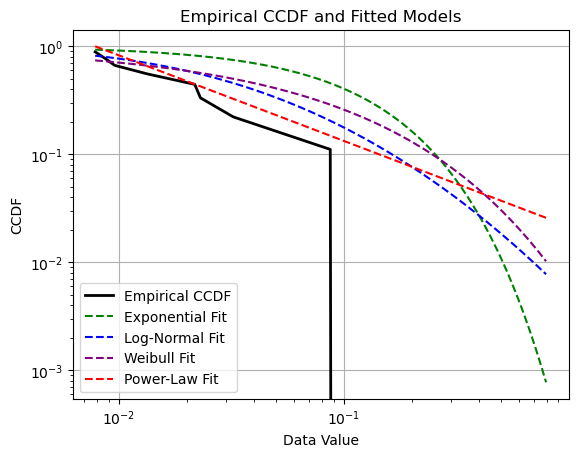


AIC/BIC Table:


,Distribution,Num Parameters,Log-Likelihood,AIC,BIC,AIC Difference,BIC Difference
0,Exponential,2,10.812504,-17.625008,-17.230559,20.728653,20.728653
1,Log-Normal,3,16.568898,-27.137795,-26.546122,11.215865,11.413090
2,Weibull,3,14.414256,-22.828513,-22.236839,15.525148,15.722373
3,Power-Law,2,21.176830,-38.353661,-37.959212,0.000000,0.000000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, lognorm, weibull_min, kstest
import powerlaw
import pandas as pd  # For DataFrame

# Data (replace with your actual data)
data = depth_data['PerDepthFillProbability']

# Function to compute empirical CCDF
def compute_empirical_ccdf(data):
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(data) + 1) / len(data)
    return sorted_data, ccdf

# Function to compute AIC and BIC
def compute_aic_bic(log_likelihood, num_params, num_data_points):
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_data_points) - 2 * log_likelihood
    return aic, bic

# Function to compute log-likelihood for a power-law fit
def compute_powerlaw_loglikelihood(data, alpha, xmin):
    tail_data = data[data >= xmin]
    n = len(tail_data)
    log_likelihood = n * np.log(alpha - 1) - n * np.log(xmin) - alpha * np.sum(np.log(tail_data / xmin))
    return log_likelihood

# Main analysis function
def analyze_distributions(data):
    print("Estimated Parameters, Kolmogorov-Smirnov (KS) Test, and Model Selection Criteria (AIC/BIC):\n")
    n = len(data)  # Number of data points
    aic_bic_rows = []  # Store data for the AIC/BIC table

    # Exponential Fit
    loc_exp, scale_exp = expon.fit(data, floc=0)
    log_likelihood_exp = np.sum(expon.logpdf(data, loc=loc_exp, scale=scale_exp))
    aic_exp, bic_exp = compute_aic_bic(log_likelihood_exp, 2, n)
    ks_stat_exp, p_value_exp = kstest(data, 'expon', args=(loc_exp, scale_exp))
    print(f"Exponential Fit: loc={loc_exp:.6f}, scale={scale_exp:.6f}, "
          f"KS Statistic={ks_stat_exp:.6f}, P-Value={p_value_exp:.6f}, "
          f"AIC={aic_exp:.6f}, BIC={bic_exp:.6f}")
    aic_bic_rows.append(['Exponential', 2, log_likelihood_exp, aic_exp, bic_exp])

    # Log-Normal Fit
    shape_ln, loc_ln, scale_ln = lognorm.fit(data, floc=0)
    log_likelihood_ln = np.sum(lognorm.logpdf(data, shape_ln, loc_ln, scale_ln))
    aic_ln, bic_ln = compute_aic_bic(log_likelihood_ln, 3, n)
    ks_stat_ln, p_value_ln = kstest(data, 'lognorm', args=(shape_ln, loc_ln, scale_ln))
    print(f"Log-Normal Fit: shape={shape_ln:.6f}, loc={loc_ln:.6f}, scale={scale_ln:.6f}, "
          f"KS Statistic={ks_stat_ln:.6f}, P-Value={p_value_ln:.6f}, "
          f"AIC={aic_ln:.6f}, BIC={bic_ln:.6f}")
    aic_bic_rows.append(['Log-Normal', 3, log_likelihood_ln, aic_ln, bic_ln])

    # Weibull Fit
    shape_weibull, loc_weibull, scale_weibull = weibull_min.fit(data, floc=0)
    log_likelihood_weibull = np.sum(weibull_min.logpdf(data, shape_weibull, loc_weibull, scale_weibull))
    aic_weibull, bic_weibull = compute_aic_bic(log_likelihood_weibull, 3, n)
    ks_stat_weibull, p_value_weibull = kstest(data, 'weibull_min', args=(shape_weibull, loc_weibull, scale_weibull))
    print(f"Weibull Fit: shape={shape_weibull:.6f}, loc={loc_weibull:.6f}, scale={scale_weibull:.6f}, "
          f"KS Statistic={ks_stat_weibull:.6f}, P-Value={p_value_weibull:.6f}, "
          f"AIC={aic_weibull:.6f}, BIC={bic_weibull:.6f}")
    aic_bic_rows.append(['Weibull', 3, log_likelihood_weibull, aic_weibull, bic_weibull])

    # Power-Law Fit
    fit = powerlaw.Fit(data, verbose=False)
    alpha = fit.alpha
    xmin = fit.xmin
    log_likelihood_powerlaw = compute_powerlaw_loglikelihood(data, alpha, xmin)
    aic_powerlaw, bic_powerlaw = compute_aic_bic(log_likelihood_powerlaw, 2, n)
    powerlaw_ks_stat = fit.power_law.KS()
    print(f"Power-Law Fit: alpha={alpha:.6f}, xmin={xmin:.6f}, "
          f"KS Statistic={powerlaw_ks_stat:.6f}, "
          f"AIC={aic_powerlaw:.6f}, BIC={bic_powerlaw:.6f}")
    print("Note: P-value for Power-Law is not directly provided by the library.\n")
    aic_bic_rows.append(['Power-Law', 2, log_likelihood_powerlaw, aic_powerlaw, bic_powerlaw])

    # Create AIC/BIC Data Table
    aic_bic_data = pd.DataFrame(aic_bic_rows, columns=['Distribution', 'Num Parameters', 'Log-Likelihood', 'AIC', 'BIC'])

    # Plot CCDFs
    fig, ax = plt.subplots()

    # Compute empirical CCDF
    sorted_data, empirical_ccdf = compute_empirical_ccdf(data)

    ax.plot(sorted_data, empirical_ccdf, label="Empirical CCDF", color='black', linewidth=2)

    # Plot Exponential Fit
    x = np.linspace(min(data), max(data), 1000)
    exp_ccdf = 1 - expon.cdf(x, loc=loc_exp, scale=scale_exp)
    ax.plot(x, exp_ccdf, label="Exponential Fit", linestyle='--', color='green')

    # Plot Log-Normal Fit
    lognorm_ccdf = 1 - lognorm.cdf(x, shape_ln, loc_ln, scale_ln)
    ax.plot(x, lognorm_ccdf, label="Log-Normal Fit", linestyle='--', color='blue')

    # Plot Weibull Fit
    weibull_ccdf = 1 - weibull_min.cdf(x, shape_weibull, loc=loc_weibull, scale=scale_weibull)
    ax.plot(x, weibull_ccdf, label="Weibull Fit", linestyle='--', color='purple')

    # Plot Power-Law Fit
    powerlaw_x = np.linspace(fit.xmin, max(data), 1000)
    powerlaw_ccdf = fit.power_law.ccdf(powerlaw_x)
    ax.plot(powerlaw_x, powerlaw_ccdf, label="Power-Law Fit", linestyle='--', color='red')

    # Enhance the plot
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Data Value')
    ax.set_ylabel('CCDF')
    ax.set_title('Empirical CCDF and Fitted Models')
    ax.legend()
    ax.grid()
    ax.ylim = (1e-4, 1) 

    plt.show()

    # Return the AIC/BIC table
    return aic_bic_data

# Call the function to analyze distributions and get the AIC/BIC table
aic_bic_data = analyze_distributions(data)

# Add AIC difference and BIC difference columns
aic_bic_data['AIC Difference'] = aic_bic_data['AIC'] - aic_bic_data['AIC'].min()
aic_bic_data['BIC Difference'] = aic_bic_data['BIC'] - aic_bic_data['BIC'].min()

# Display the AIC/BIC table with differences
print("\nAIC/BIC Table:")
aic_bic_data





## Fill Probability, filled within a defined time interval

In [21]:

import pandas as pd
from datetime import timedelta

# Initialize data structures with modified variable names
filled_depth_count_v2 = {}  # Depth -> Total filled size 
# Modified for event 4 only

posted_depth_count_v2 = {}  # Depth -> Total posted size
# Modfied for event 1, 2, 3

order_depth_map_v2 = {}     # Order ID -> Depth posted
# No modification as the depth is fixed at posting (but can be deleted for event 3)


order_size_map_v2 = {}      # Order ID -> Size posted
# Added for event 1, and modified for event 2, deleted for event 3, modified for event 4

orderid_time_dict_v2 = {}   # Order ID -> Timestamp when posted
# Added for event 1, deleted for event 3, or when iterating thru in event 4 for efficiency sake

filled_timestamp_set = set()  # Set to store timestamps of filled orders

# Configurable time threshold (e.g., 1 minute)
time_threshold_v2 = timedelta(seconds=5)

# Process the message data row by row
for index, row in message_data.iterrows():
    # Extract relevant fields
    timestamp = index                  # Timestamp is the index
    event_type = row['EventType']      # Type of event (1: Add, 2: Partial Cancel, etc.)
    order_id = row['OrderID']          # Unique ID for the order
    size = row['Size']                 # Size of the order/event
    depth = row['DepthAtPosting']      # Depth at which the order was posted

    # Event type 1: New order posted to the book
    if event_type == 1:
        order_depth_map_v2[order_id] = depth
        order_size_map_v2[order_id] = size
        orderid_time_dict_v2[order_id] = timestamp  # Store the time the order was posted
        if depth not in posted_depth_count_v2:
            posted_depth_count_v2[depth] = 0
        posted_depth_count_v2[depth] += size

    # # Event type 2: Partial cancellation of an existing order
    # elif event_type == 2:
    #     if order_id in order_depth_map_v2:
    #         order_size_map_v2[order_id] -= size
    #         posted_depth_count_v2[order_depth_map_v2[order_id]] -= size
    #         if posted_depth_count_v2[order_depth_map_v2[order_id]] < 0:
    #             raise ValueError(f"Negative size detected for depth {order_depth_map_v2[order_id]}")

    #         if order_size_map_v2[order_id] < 0:
    #             raise ValueError(f"Negative size detected for order {order_id}, likely an implementation error") 

    # # Event type 3: Full cancellation of an existing order
    # elif event_type == 3:
    #     if order_id in order_depth_map_v2:
    #         depth = order_depth_map_v2[order_id]
    #         posted_depth_count_v2[depth] -= order_size_map_v2[order_id]
    #         post_debug_string_v2 += f"Order {order_id} fully cancelled and size deducted by {order_size_map_v2[order_id]}\n"
    #         # Remove order from tracking maps
    #         del order_depth_map_v2[order_id]
    #         del order_size_map_v2[order_id]
    #         del orderid_time_dict_v2[order_id]

    # Event type 4: Market order fill
    elif event_type == 4:
        if order_id in order_depth_map_v2:
            # Check if the order was posted within the time threshold
            if order_id in orderid_time_dict_v2:
                order_post_time = orderid_time_dict_v2[order_id]
                if timestamp - order_post_time <= time_threshold_v2:
                    depth = order_depth_map_v2[order_id]
                    if depth not in filled_depth_count_v2:
                        filled_depth_count_v2[depth] = 0
                    filled_depth_count_v2[depth] += size
                    # Reduce the remaining size for the order
                    order_size_map_v2[order_id] -= size

                    filled_timestamp_set.add(timestamp - order_post_time)

    # Ignore other event types

# Convert dictionaries to DataFrames
posted_df_v2 = pd.DataFrame(posted_depth_count_v2.items(), columns=['Depth', 'PostedOrders'])
filled_df_v2 = pd.DataFrame(filled_depth_count_v2.items(), columns=['Depth', 'FilledOrders'])

# Merge posted and filled data
depth_data_v2 = pd.merge(posted_df_v2, filled_df_v2, on='Depth', how='left').fillna(0)

# Ensure numeric types for calculations
depth_data_v2['PostedOrders'] = depth_data_v2['PostedOrders'].astype(float)
depth_data_v2['FilledOrders'] = depth_data_v2['FilledOrders'].astype(float)

# Sort by depth
depth_data_v2 = depth_data_v2.sort_values(by='Depth')

# Calculate totals
total_filled_orders_v2 = depth_data_v2['FilledOrders'].sum()
total_posted_orders_v2 = depth_data_v2['PostedOrders'].sum()

print("Total filled orders (v2):", total_filled_orders_v2)
print("Total posted orders (v2):", total_posted_orders_v2)

# Filter depths and calculate fill probability
depth_data_v2['FillProbability'] = depth_data_v2['FilledOrders'] / depth_data_v2['PostedOrders']

# New column called AggFillProbability, calculated as proportion of orders from certain depth that are filled
depth_data_v2['AggFillProbability'] = depth_data_v2['FilledOrders'].cumsum() / total_filled_orders_v2

# Column for per-depth contribution to total fill
depth_data_v2['PerDepthFillProbability'] = depth_data_v2['FilledOrders'] / total_filled_orders_v2

# Cutoff where aggregate fill probability is 0.99
cutoff_depth_v2 = depth_data_v2[depth_data_v2['AggFillProbability'] >= 0.99].iloc[0]['Depth']
print("Cutoff depth for 99% fill probability (v2):", cutoff_depth_v2)

# Filter to only include depths up to the cutoff
depth_data_v2 = depth_data_v2[depth_data_v2['Depth'] <= cutoff_depth_v2]

# Print max and min from the timestamp set
max_timestamp = max(filled_timestamp_set)
min_timestamp = min(filled_timestamp_set)
print("Max Timestamp:", max_timestamp)
print("Min Timestamp:", min_timestamp)
print("Time threshold:", time_threshold_v2)

# print total posted and total filled for both original and v2
print("Total filled orders:", total_filled_orders)
print("Total posted orders:", total_posted_orders)

print("Total filled orders (v2):", total_filled_orders_v2)
print("Total posted orders (v2):", total_posted_orders_v2)

# compare v2 as a percentage of original
# Calculate the percentage of filled orders (v2) compared to filled orders (original)
filled_orders_percentage_v2 = (total_filled_orders_v2 / total_filled_orders) * 100
posted_orders_percentage_v2 = (total_posted_orders_v2 / total_posted_orders) * 100

print(f"Percentage of filled orders (v2) compared to filled orders (original): {filled_orders_percentage_v2:.4f}%")
print(f"Percentage of posted orders (v2) compared to posted orders (original): {posted_orders_percentage_v2:.4f}%")

# Display the resulting DataFrame
depth_data_v2



Total filled orders (v2): 2938473.0
Total posted orders (v2): 47701650.0
Cutoff depth for 99% fill probability (v2): 5.0
Max Timestamp: 0 days 00:00:04.998892544
Min Timestamp: 0 days 00:00:00
Time threshold: 0:00:05
Total filled orders: 3562727.0
Total posted orders: 47701650.0
Total filled orders (v2): 2938473.0
Total posted orders (v2): 47701650.0
Percentage of filled orders (v2) compared to filled orders (original): 82.4782%
Percentage of posted orders (v2) compared to posted orders (original): 100.0000%


,Depth,PostedOrders,FilledOrders,FillProbability,AggFillProbability,PerDepthFillProbability
0,0.0,24122473.0,2547624.0,0.105612,0.866989,0.866989
1,1.0,7783143.0,229978.0,0.029548,0.945254,0.078264
5,2.0,4061038.0,59372.0,0.014620,0.965459,0.020205
12,3.0,3553016.0,31721.0,0.008928,0.976254,0.010795
15,4.0,3754505.0,24491.0,0.006523,0.984588,0.008335
14,5.0,1093780.0,20704.0,0.018929,0.991634,0.007046


In [22]:
# check Depth and FillProbability columns
depth_data_v2[['PostedOrders',	'FilledOrders', 'FillProbability']]

,PostedOrders,FilledOrders,FillProbability
0,24122473.0,2547624.0,0.105612
1,7783143.0,229978.0,0.029548
5,4061038.0,59372.0,0.014620
12,3553016.0,31721.0,0.008928
15,3754505.0,24491.0,0.006523
14,1093780.0,20704.0,0.018929


In [23]:
# drop index
depth_data_v2 = depth_data_v2.reset_index(drop=True)

# make column Depth as index
depth_data_v2.set_index('Depth', inplace=True)

depth_data_v2

,PostedOrders,FilledOrders,FillProbability,AggFillProbability,PerDepthFillProbability
Depth,,,,,
0.0,24122473.0,2547624.0,0.105612,0.866989,0.866989
1.0,7783143.0,229978.0,0.029548,0.945254,0.078264
2.0,4061038.0,59372.0,0.014620,0.965459,0.020205
3.0,3553016.0,31721.0,0.008928,0.976254,0.010795
4.0,3754505.0,24491.0,0.006523,0.984588,0.008335
5.0,1093780.0,20704.0,0.018929,0.991634,0.007046


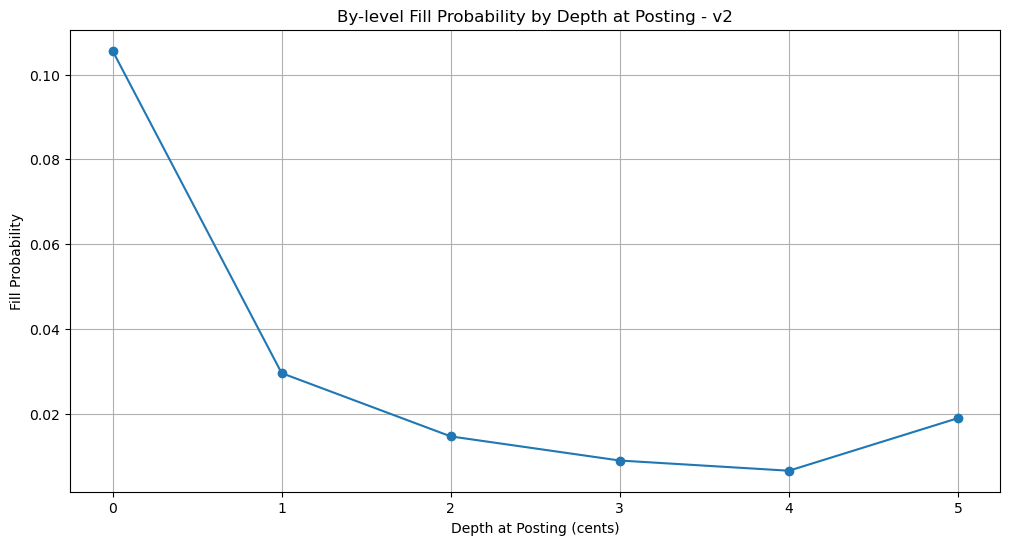

In [24]:
# Plot fill probability by depth (v2)
# x-axis: Depth at Posting (cents) (median of each bin)
# y-axis: AvgFillProbability (average fill probability of each bin)
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data_v2.index,
    depth_data_v2['FillProbability'],
    marker='o'
)

plt.xlabel('Depth at Posting (cents)')
plt.ylabel('Fill Probability')
plt.title('By-level Fill Probability by Depth at Posting - v2')
plt.grid(True)
plt.show()


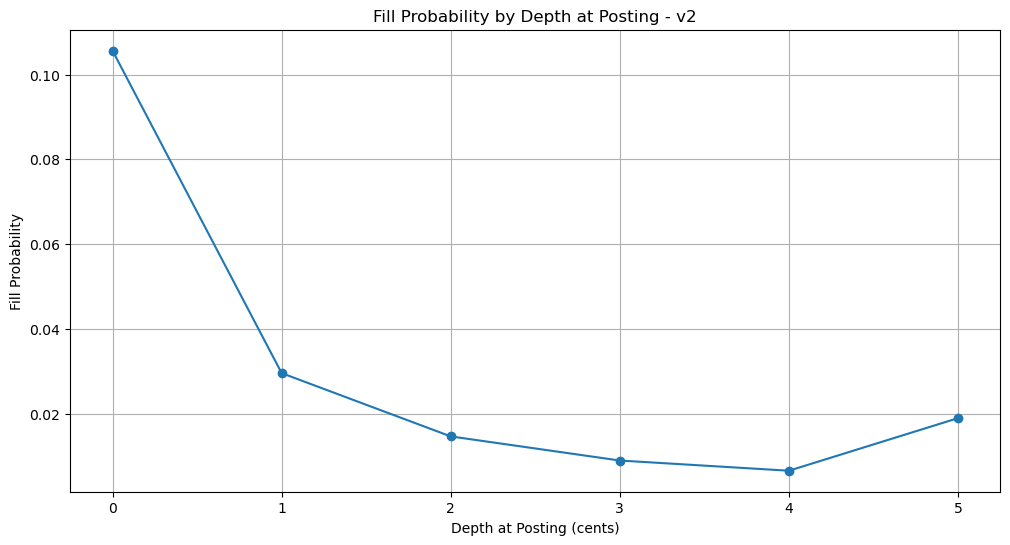

In [25]:
# Plot fill probability by depth (v2)
# x-axis: Depth at Posting (cents) (median of each bin)
# y-axis: AvgFillProbability (average fill probability of each bin)
plt.figure(figsize=(12, 6))
plt.plot(
    depth_data_v2.index,
    depth_data_v2['FillProbability'],
    marker='o'
)

plt.xlabel('Depth at Posting (cents)')
plt.ylabel('Fill Probability')
plt.title('Fill Probability by Depth at Posting - v2')
plt.grid(True)
plt.show()


Adaptive Shift (v2): 1.0000
After log transformation:
(6,)
(6,)
After slicing:
(5,)
(5,)
R2 Score (v2): 0.9987
Slope (v2): -1.7437, Intercept (v2): -2.2796


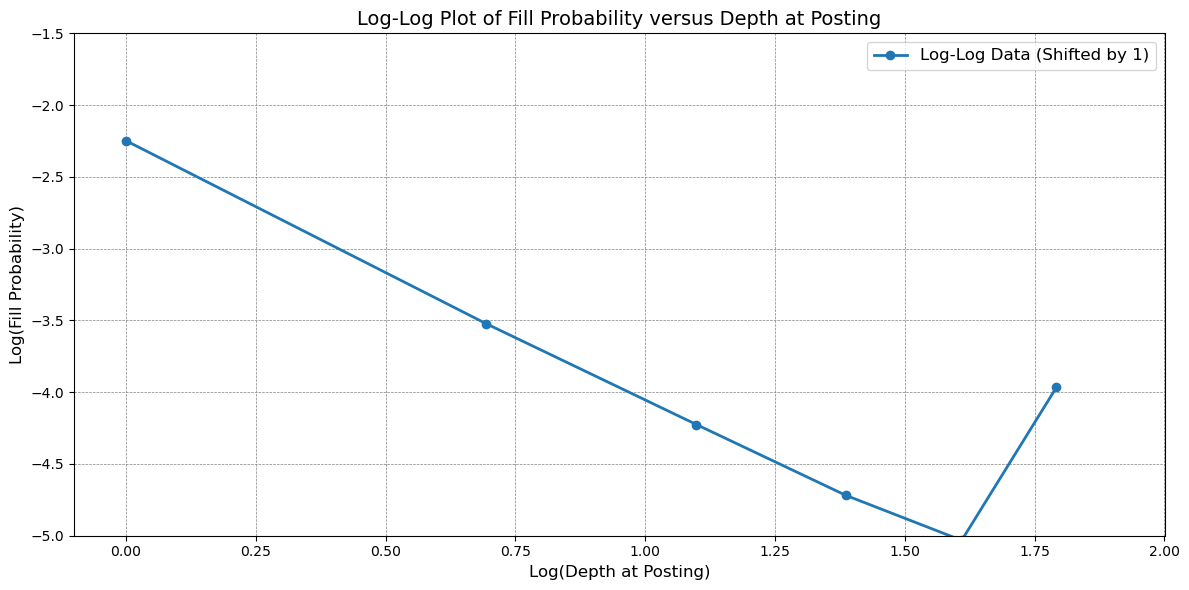

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Copy the Depth and PerDepthFillProbability columns to preserve original data (v2)
x_v2 = depth_data_v2.index.copy()
y_v2 = depth_data_v2['FillProbability'].copy()

# make x_v2 a Pandas Series
x_v2 = pd.Series(x_v2)

# # Drop the first element from the copied data
# x_v2 = x_v2.iloc[1:].reset_index(drop=True)
# y_v2 = y_v2.iloc[1:].reset_index(drop=True)

shift_v2 = 1   # Shift everything by 1

# print adaptive shift info
print(f"Adaptive Shift (v2): {shift_v2:.4f}")

# Add shift to all x values
x_shifted_v2 = x_v2 + shift_v2

# Apply log transformation
x_log_v2 = np.log(x_shifted_v2)
y_log_v2 = np.log(y_v2)

print("After log transformation:")
print(x_log_v2.shape)
print(y_log_v2.shape)


# Fit a linear regression model to the log-log data (v2)
# only first 4 points
x_log_v2_regression = x_log_v2[:5]
y_log_v2_regression = y_log_v2[:4]

print("After slicing:")
print(x_log_v2_regression.shape)
print(y_log_v2_regression.shape)

model_v2 = LinearRegression(fit_intercept=True)
model_v2.fit(x_log_v2_regression.values.reshape(-1, 1), y_log_v2_regression)
slope_v2 = model_v2.coef_[0]
intercept_v2 = model_v2.intercept_

# check r2 score for goodness of fit
r2_score_v2 = model_v2.score(x_log_v2_regression.values.reshape(-1, 1), y_log_v2_regression)
print(f"R2 Score (v2): {r2_score_v2:.4f}")

print(f"Slope (v2): {slope_v2:.4f}, Intercept (v2): {intercept_v2:.4f}")

import matplotlib.pyplot as plt

# Plot log-log data with enhanced style
plt.figure(figsize=(12, 6))

# Plot the data with a cleaner line style and larger markers
plt.plot(
    x_log_v2, y_log_v2, 
    marker='o', 
    markersize=6, 
    linestyle='-', 
    linewidth=2, 
    label='Log-Log Data (Shifted by 1)'
)

# Add labels with improved font size
plt.xlabel('Log(Depth at Posting)', fontsize=12)
plt.ylabel('Log(Fill Probability)', fontsize=12)

# Add a title with improved font size
plt.title('Log-Log Plot of Fill Probability versus Depth at Posting', fontsize=14)

# Add a grid with lighter lines for a professional look
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Add legend and draw the figure to calculate legend position
legend = plt.legend(fontsize=12, loc='best', frameon=True)

plt.ylim(-5, -1.5)
plt.xlim(-0.1, 2)

# Show the plot
plt.tight_layout()  # Ensures layout is clean and not overlapping
plt.savefig('fill_probability_log_log_plot.png', dpi=600)  # Save the plot as a high-resolution image
plt.show()


In [27]:
print(f'Intercept is {np.exp(intercept_v2):.4f} and slope is {slope_v2:.4f}')

Intercept is 0.1023 and slope is -1.7437


In [28]:
import numpy as np
import pandas as pd

# Define the fill prediction function with a cap at 1
# And for depth >= 4, assume a constant fill probability of 1%
def fill_function(x):
    if x < 5:
        return min(np.exp(intercept_v2) * x ** slope_v2, 1)
    else:
        return 0.01

# Make a copy of the dataset for checking
fill_check_df = depth_data_v2.copy()

# Add 1 to the depth index for predictions to account for the shift during calibration
# Assuming 'Index' is the column representing depth
# Generate predictions by adding 1 to the index
fill_check_df['PredictedFill'] = [fill_function(x + 1) for x in fill_check_df.index]

print([x+1 for x in fill_check_df.index])


# Drop columns that are not needed
if 'AggFillProbability' in fill_check_df.columns:
    fill_check_df = fill_check_df.drop(columns=['AggFillProbability', 'PerDepthFillProbability'])

# Calculate percentage difference between actual and predicted fill probabilities
fill_check_df['PctDiff'] = ((fill_check_df['FillProbability'] - fill_check_df['PredictedFill']) / fill_check_df['FillProbability']) * 100

# convert FillProbability and PredictedFill to percentage
fill_check_df['FillProbability'] = fill_check_df['FillProbability'] * 100

fill_check_df['PredictedFill'] = fill_check_df['PredictedFill'] * 100

print("Note: all values are quoted in percentage points.")

# Return the dataframe for inspection
fill_check_df


[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Note: all values are quoted in percentage points.


,PostedOrders,FilledOrders,FillProbability,PredictedFill,PctDiff
Depth,,,,,
0.0,24122473.0,2547624.0,10.561206,10.232561,3.111814
1.0,7783143.0,229978.0,2.954822,3.055411,-3.404230
2.0,4061038.0,59372.0,1.461991,1.506656,-3.055108
3.0,3553016.0,31721.0,0.892791,0.912336,-2.189233
4.0,3754505.0,24491.0,0.652310,1.000000,-53.301417
5.0,1093780.0,20704.0,1.892885,1.000000,47.170595


In [29]:
import powerlaw
import numpy as np

# Data: Fill probabilities and corresponding depths
depths = np.array([1,2,3,4])  # Depth levels (first 4 points)
fill_probabilities = depth_data_v2['FillProbability'].copy()[:4] # Fill probabilitiesprint(y_v2

[print(a,b) for a,b in zip(depths, fill_probabilities)]

# Fit the power-law model using powerlaw package
data = powerlaw.Fit(fill_probabilities)

# Output the parameters for the fit
alpha = data.alpha  # Power-law exponent
xmin = data.xmin    # Minimum value for power-law behavior

# Print the results
print(f"Power-law exponent (alpha): {alpha}")
print(f"Xmin (start of power-law behavior): {xmin}")

1 0.10561205727124247
2 0.02954821721764588
3 0.014619907521180546
4 0.008927908008294924
Calculating best minimal value for power law fit
Power-law exponent (alpha): 1.9231964815472167
Xmin (start of power-law behavior): 0.006523096919567293


In [30]:
# import matplotlib.pyplot as plt

# # Visualize Depth vs AggFillProbability (v2)
# plt.figure(figsize=(12, 6))
# plt.plot(
#     depth_data_v2['Depth'],
#     depth_data_v2['AggFillProbability'],
#     marker='o'
# )

# plt.xlabel('Depth at Posting (cents)')
# plt.ylabel('Aggregated Fill Probability')
# plt.title('Aggregated Fill Probability by Depth at Posting (Eventual Fill) - v2')
# plt.grid(True)
# plt.show()


In [31]:
# merge original and v2 data
depth_data_merged = pd.merge(depth_data, depth_data_v2, on='Depth', suffixes=('_original', '_v2'), how='inner')

depth_data_merged

# Keep these columns, Posted_Orders, Filled_Orders, AggFillProbability, PerDepthFillProbability_original, for both original and v2
# Column orders should appear as original and then v2, one by one alternating
depth_data_merged = depth_data_merged[['Depth', 'PostedOrders_original', 'PostedOrders_v2', 
                                       'FilledOrders_original', 'FilledOrders_v2', 
                                       'AggFillProbability_original', 'AggFillProbability_v2', 
                                       'PerDepthFillProbability_original', 'PerDepthFillProbability_v2']]

# print total posted and total filled for both original and v2
print("Total filled orders:", total_filled_orders)
print("Total posted orders:", total_posted_orders)

print("Total filled orders (v2):", total_filled_orders_v2)
print("Total posted orders (v2):", total_posted_orders_v2)

# compare v2 as a percentage of original
# Calculate the percentage of filled orders (v2) compared to filled orders (original)
filled_orders_percentage_v2 = (total_filled_orders_v2 / total_filled_orders) * 100
posted_orders_percentage_v2 = (total_posted_orders_v2 / total_posted_orders) * 100

print(f"Percentage of filled orders (v2) compared to filled orders (original): {filled_orders_percentage_v2:.4f}%")
print(f"Percentage of posted orders (v2) compared to posted orders (original): {posted_orders_percentage_v2:.4f}%")

# Add a column called PostOrderPercentage, calculated as the percentage of posted orders (v2) compared to posted orders (original)
depth_data_merged['PostOrderPercentage'] = (depth_data_merged['PostedOrders_v2'] / depth_data_merged['PostedOrders_original']) * 100


depth_data_merged

Total filled orders: 3562727.0
Total posted orders: 47701650.0
Total filled orders (v2): 2938473.0
Total posted orders (v2): 47701650.0
Percentage of filled orders (v2) compared to filled orders (original): 82.4782%
Percentage of posted orders (v2) compared to posted orders (original): 100.0000%


,Depth,PostedOrders_original,PostedOrders_v2,FilledOrders_original,FilledOrders_v2,AggFillProbability_original,AggFillProbability_v2,PerDepthFillProbability_original,PerDepthFillProbability_v2,PostOrderPercentage
0,0.0,24122473.0,24122473.0,2823531.0,2547624.0,0.792520,0.866989,0.792520,0.866989,100.0
1,1.0,7783143.0,7783143.0,309869.0,229978.0,0.879495,0.945254,0.086975,0.078264,100.0
2,2.0,4061038.0,4061038.0,114763.0,59372.0,0.911707,0.965459,0.032212,0.020205,100.0
3,3.0,3553016.0,3553016.0,77370.0,31721.0,0.933423,0.976254,0.021717,0.010795,100.0
4,4.0,3754505.0,3754505.0,82031.0,24491.0,0.956448,0.984588,0.023025,0.008335,100.0
5,5.0,1093780.0,1093780.0,47597.0,20704.0,0.969808,0.991634,0.013360,0.007046,100.0
